# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from numpy.polynomial import Polynomial

# Load Dataset

In [3]:
url = "https://faculty.chicagobooth.edu/-/media/faculty/ruey-s-tsay/teaching/fts3/dgnp82.txt"
gnp = pd.read_csv(url, header=None, names=["GNP"])

# Construct quarterly dates starting from 1947Q1
dates = pd.period_range(start="1947Q1", periods=len(gnp), freq="Q").to_timestamp()
gnp["Date"] = dates

print(gnp.head())
print("Shape:", gnp.shape)

       GNP       Date
0  0.00632 1947-01-01
1  0.00366 1947-04-01
2  0.01202 1947-07-01
3  0.00627 1947-10-01
4  0.01761 1948-01-01
Shape: (176, 2)


# Plot

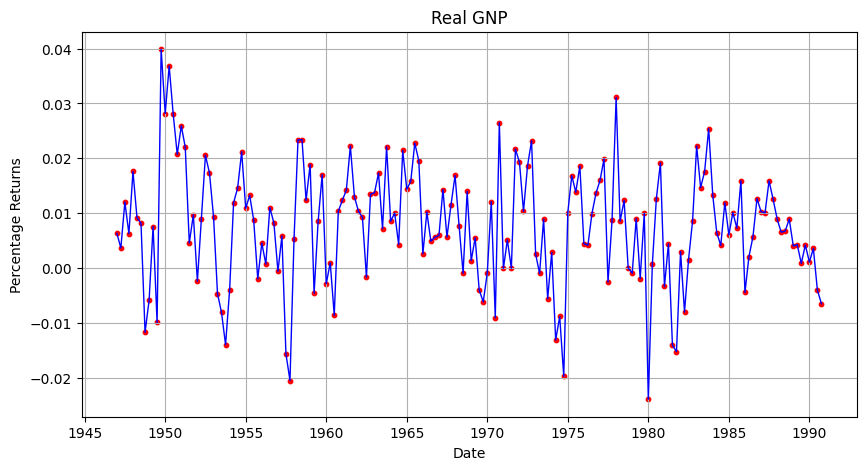

In [4]:
# 2 Plot GNP series
plt.figure(figsize=(10,5))
plt.plot(gnp["Date"], gnp["GNP"], color="blue", linewidth=1)
plt.scatter(gnp["Date"], gnp["GNP"], color="red", s=10)
plt.title("Real GNP")
plt.xlabel("Date")
plt.ylabel("Percentage Returns")
plt.grid(True)
plt.show()

# ACF

<Figure size 1000x500 with 0 Axes>

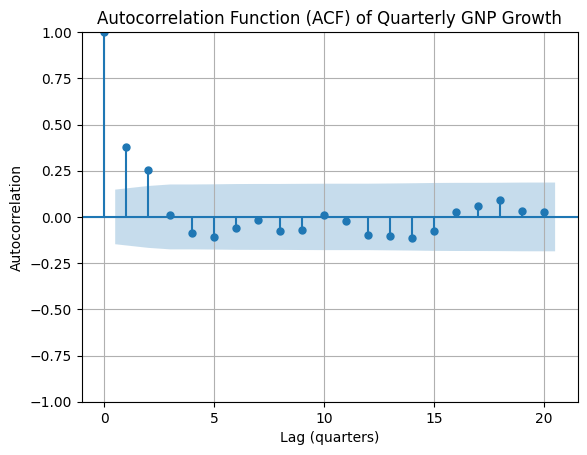

In [17]:

# Plot ACF for the growth rate series
plt.figure(figsize=(10,5))
plot_acf(gnp["GNP"], lags=20)  # you can adjust lags as needed
plt.title("Autocorrelation Function (ACF) of Quarterly GNP Growth")
plt.xlabel("Lag (quarters)")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.show()

# AR(p) Model Selection

In [43]:
from statsmodels.tsa.ar_model import ar_select_order, AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox

# Select the best AR lags up to maxlag=12 using AIC
mod = ar_select_order(gnp["GNP"], maxlag=12, ic='aic', old_names=False)
selected_lags = mod.ar_lags
print(f"Selected AR lags by AIC: {selected_lags}")

best_ar_order = max(selected_lags) if len(selected_lags) > 0 else 0
print(f"The best AR model according to AIC uses lags: {selected_lags}, roughly AR({best_ar_order})")

# Fit the AR model with the selected lags and show summary
res = AutoReg(gnp["GNP"], lags=selected_lags, old_names=False).fit()
print("\n--- AR Model Fit Summary ---")
print(res.summary())

out = 'AIC: {0:0.3f}, HQIC: {1:0.3f}, BIC: {2:0.3f}'
print(out.format(res.aic, res.hqic, res.bic))

Selected AR lags by AIC: [1, 2, 3]
The best AR model according to AIC uses lags: [1, 2, 3], roughly AR(3)

--- AR Model Fit Summary ---
                            AutoReg Model Results                             
Dep. Variable:                    GNP   No. Observations:                  176
Model:                     AutoReg(3)   Log Likelihood                 555.080
Method:               Conditional MLE   S.D. of innovations              0.010
Date:                Tue, 23 Sep 2025   AIC                          -1100.160
Time:                        14:18:08   BIC                          -1084.393
Sample:                             3   HQIC                         -1093.763
                                  176                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.001      4.496      0.000       0.003       0

# Average Cycle Length

In [46]:
import numpy as np

# Extract AR coefficients
ar_coeffs = res.params[1:]  # skip intercept
# Identify complex roots from the summary roots
roots = np.roots(np.concatenate(([1], -ar_coeffs)))

# Compute average cycle length (quarters) using the first complex root
complex_root = roots[np.iscomplex(roots)][0]
cycle_length = 2 * np.pi / np.angle(complex_root)
print("\nAverage cycle length (quarters):", cycle_length)


Average cycle length (quarters): 10.67348014871281


# ARIMA

In [42]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(gnp["GNP"], order=(3,0,0))
res = model.fit()

print(res.summary())

print("\nCoefficients:", res.params)
print("Standard errors:", res.bse)
print("Sigma^2:", res.params["sigma2"])   # fixed
print("Log-likelihood:", res.llf)
print("AIC:", res.aic)

                               SARIMAX Results                                
Dep. Variable:                    GNP   No. Observations:                  176
Model:                 ARIMA(3, 0, 0)   Log Likelihood                 565.842
Date:                Tue, 23 Sep 2025   AIC                          -1121.685
Time:                        14:06:14   BIC                          -1105.832
Sample:                             0   HQIC                         -1115.255
                                - 176                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0077      0.001      6.176      0.000       0.005       0.010
ar.L1          0.3488      0.071      4.910      0.000       0.210       0.488
ar.L2          0.1784      0.073      2.452      0.0